Mount Google Drive

In [ ]:
# Mount Google Drive if not already mounted
from google.colab import drive
drive.mount('/content/drive')

# Copy dataset to Colab local runtime (faster training)
!cp -r "/content/drive/MyDrive/Medical/chest_xray" /content/


Mounted at /content/drive


Set the path:

In [ ]:
import os
import shutil
import random
from glob import glob
from pathlib import Path
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
random.seed(42)

# Source folders
original_dirs = [
    '/content/chest_xray/train',
    '/content/chest_xray/val',
    '/content/chest_xray/test'
]

# Target folder
base_dir = '/content/pneumonia_dataset'
classes = ['NORMAL', 'PNEUMONIA']

# Create new structure
for split in ['train', 'val', 'test']:
    for cls in classes:
        Path(f'{base_dir}/{split}/{cls}').mkdir(parents=True, exist_ok=True)

# Collect all images by class
all_images = {cls: [] for cls in classes}
for d in original_dirs:
    for cls in classes:
        all_images[cls].extend(glob(os.path.join(d, cls, '*.jpeg')))

# Shuffle and split for each class
for cls, imgs in all_images.items():
    random.shuffle(imgs)
    train, test_val = train_test_split(imgs, test_size=0.3, random_state=42)
    val, test = train_test_split(test_val, test_size=0.5, random_state=42)

    # Copy images to new folders
    for split_name, split_imgs in zip(['train', 'val', 'test'], [train, val, test]):
        for img_path in split_imgs:
            shutil.copy(img_path, f'{base_dir}/{split_name}/{cls}/')

print("✅ Dataset re-splitting complete. New structure created at:")
print(base_dir)


✅ Dataset re-splitting complete. New structure created at:
/content/pneumonia_dataset


Code to Load the Dataset:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32

# Augment training data, but not val/test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Define directories
base_dir = "/content/pneumonia_dataset"

train_gen = train_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'val'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # important for evaluation
)


Found 4127 images belonging to 2 classes.
Found 884 images belonging to 2 classes.
Found 885 images belonging to 2 classes.


Build Model Using MobileNetV2

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Load base MobileNetV2 (no top layers, freeze weights)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Train the Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks to stop early and save best model
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.8607 - loss: 0.3238
Epoch 1: val_accuracy improved from -inf to 0.93100, saving model to best_model.h5


129/129 ━━━━━━━━━━━━━━━━━━━━ 108s 745ms/step - accuracy: 0.8610 - loss: 0.3231 - val_accuracy: 0.9310 - val_loss: 0.1521
Epoch 2/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.9266 - loss: 0.1755
Epoch 2: val_accuracy improved from 0.93100 to 0.93326, saving model to best_model.h5


129/129 ━━━━━━━━━━━━━━━━━━━━ 83s 648ms/step - accuracy: 0.9267 - loss: 0.1754 - val_accuracy: 0.9333 - val_loss: 0.1595
Epoch 3/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.9354 - loss: 0.1599
Epoch 3: val_accuracy improved from 0.93326 to 0.93552, saving model to best_model.h5


129/129 ━━━━━━━━━━━━━━━━━━━━ 84s 650ms/step - accuracy: 0.9354 - loss: 0.1598 - val_accuracy: 0.9355 - val_loss: 0.1576
Epoch 4/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9416 - loss: 0.1562
Epoch 4: val_accuracy improved from 0.93552 to 0.94231, saving model to best_model.h5


129/129 ━━━━━━━━━━━━━━━━━━━━ 85s 656ms/step - accuracy: 0.9415 - loss: 0.1562 - val_accuracy: 0.9423 - val_loss: 0.1331
Epoch 5/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9414 - loss: 0.1549
Epoch 5: val_accuracy improved from 0.94231 to 0.94570, saving model to best_model.h5


129/129 ━━━━━━━━━━━━━━━━━━━━ 84s 655ms/step - accuracy: 0.9415 - loss: 0.1548 - val_accuracy: 0.9457 - val_loss: 0.1426
Epoch 6/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.9431 - loss: 0.1475
Epoch 6: val_accuracy did not improve from 0.94570
129/129 ━━━━━━━━━━━━━━━━━━━━ 84s 651ms/step - accuracy: 0.9431 - loss: 0.1476 - val_accuracy: 0.9287 - val_loss: 0.1854
Epoch 7/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.9432 - loss: 0.1420
Epoch 7: val_accuracy did not improve from 0.94570
129/129 ━━━━━━━━━━━━━━━━━━━━ 86s 664ms/step - accuracy: 0.9431 - loss: 0.1420 - val_accuracy: 0.9061 - val_loss: 0.2260


Evaluation

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 410ms/step - accuracy: 0.9332 - loss: 0.1812
Test Accuracy: 0.9537
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 383ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91       238
           1       0.96      0.98      0.97       647

    accuracy                           0.95       885
   macro avg       0.95      0.93      0.94       885
weighted avg       0.95      0.95      0.95       885



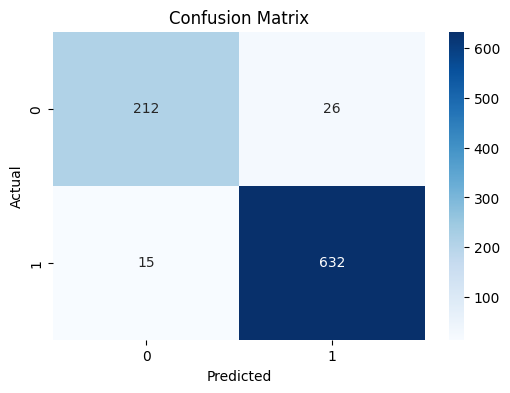

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict labels
y_pred = model.predict(test_gen)
y_pred = np.round(y_pred).flatten()

# True labels
y_true = test_gen.classes

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
model = load_model("best_model.h5")


In [ ]:
# Path to any test image
img_path = '/content/chest_xray/test/NORMAL/IM-0001-0001.jpeg'  # change accordingly

# Load image with target size
img = image.load_img(img_path, target_size=(224,224))

# Convert to array and scale pixel values
img_array = image.img_to_array(img) / 255.0

# Expand dims to match model input (1,224,224,3)
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)

# Interpret prediction
if prediction[0][0] > 0.5:
    print("Prediction: PNEUMONIA")
else:
    print("Prediction: NORMAL")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction: NORMAL
